**3.1 Linear Regression**

The dataset is called a **training dataset or training set**, and each row (containing the data corresponding to one sale) is called an **example (or data point, instance, sample)**. The thing we are trying to predict (price) is called a **label (or target)**. The variables (age and area) upon which the predictions are based are called **features (or covariates)**.

**Loss function**: quantify the distance between the real and predicted values of the target. The loss will usually be a nonnegative number where smaller values are better and perfect predictions incur a loss of 0. For regression problems, the most common loss function is the squared error. 

**Gradient descent**: an algorithm to iteratively reduce the error by updating the parameters in the direction that incrementally lowers the loss function.

**Prediction**: Given the model, we can now make predictions for a new example.

**3.1.2 Vectorization for Speed**

In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [5]:
#we vectorize the calculations and leverage fast linear algebra libraries rather than writing costly for-loops in Python
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [4]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [9]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.18876 sec'

In [12]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

**3.1.3. The Normal Distribution and Squared Loss**

In [15]:
#define a normal distribution (Gaussian distribution)
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

In [17]:
#creates an array that start with 7, stop at 7, and step with 0.01
x = np.arange(-7, 7, 0.01)
x

array([-7.  , -6.99, -6.98, ...,  6.97,  6.98,  6.99])

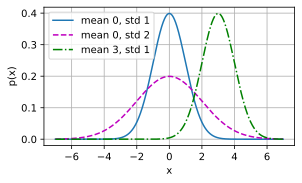

In [21]:
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])
#Note that changing the mean corresponds to a shift along the x-axis, and increasing the variance spreads the distribution out。
#linear regression with squared loss is to assume that observations arise from noisy measurements, where the noise follows the normal distribution

**3.1.4. Linear Regression as a Neural Network**

**Input layer (or feature dimensionality)**: x1, x2, ... , d  
**Output layer**: o1, o2  
**Fully-connected layer (or dense layer)**: all inputs have been connected with outputs directly.

**3.2 线性回归的从零开始实现**

In [51]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [40]:
#synthesis data
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))  #torch.normal(mean, std, size(row, column))
    y = torch.matmul(X, w) + b  #torch.matmul(A, B): performs a matrix multiplication between A and B
    y += torch.normal(0, 0.01, y.shape)  #adds noise to the previously calculated y values.
    return X, y.reshape((-1, 1))  #reshape y size into [m,1]

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [41]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.6319, 1.0589]) 
label: tensor([1.8665])


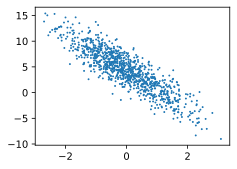

In [42]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

**3.2.2. 读取数据集**

In [56]:
#定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  #shuffle a list (reorganize the order of the list items)
    for i in range (0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [57]:
#我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 
#GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多

#读取第一个小批量数据样本并打印
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

**3.2.3. 初始化模型参数**

In [64]:
#在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数 w, b
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
#在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。

**3.2.4. 定义模型**

In [65]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

**3.2.5. 定义损失函数**

In [66]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

**3.2.6. 定义优化算法**

In [68]:
#params: model parameters; lr: learning rate
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size  #This line updates each parameter by moving it in the direction that minimally reduces the loss (opposite the gradient)
            param.grad.zero_()  #This line resets the gradients of the parameter to zero after the parameter has been updated.

**3.2.7. 训练**

In [72]:
lr = 0.03
num_epochs = 3  #迭代周期
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  #
        l.sum().backward()  #计算关于[w,b]的梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [74]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0010, 0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)


**小结**  
我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。  
这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

**3.3. 线性回归的简洁实现**

**3.3.1. 生成数据集**

In [21]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

**3.3.2. 读取数据集**

In [22]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [23]:
#使用iter构造Python迭代器，并使用next从迭代器中获取第一项
next(iter(data_iter))

[tensor([[ 0.5146, -1.4297],
         [ 0.3874,  0.4795],
         [-0.0858,  1.2093],
         [-0.2770, -1.1029],
         [-0.9491, -1.0212],
         [-0.0293,  0.8365],
         [-1.4519,  0.1539],
         [-0.3899, -0.8937],
         [ 0.9006, -1.5026],
         [ 1.4171,  0.9694]]),
 tensor([[10.1003],
         [ 3.3301],
         [-0.1058],
         [ 7.3892],
         [ 5.7730],
         [ 1.2942],
         [ 0.7694],
         [ 6.4539],
         [11.1064],
         [ 3.7468]])]

**3.3.3. 定义模型**

In [15]:
from torch import nn

#构建全连接层(fully-connected layer)
net = nn.Sequential(nn.Linear(2, 1))

**3.3.4. 初始化模型参数**

In [24]:
#通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数
#还可以使用替换方法normal_和fill_来重写参数值
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

**3.3.5. 损失函数**

In [25]:
#计算均方误差使用的是MSELoss类，也称为平方L2范数。 默认情况下，它返回所有样本损失的平均值。
loss = nn.MSELoss()

**3.3.6. 定义优化算法**

In [38]:
#小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

**3.3.7. 训练**

In [40]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()  #Zero the gradients before running the backward pass.
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000091
epoch 2, loss 0.000092
epoch 3, loss 0.000091


In [45]:
w = net[0].weight.data
print(w)
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print(b)
print('b的估计误差：', true_b - b)

tensor([[ 1.9997, -3.3998]])
w的估计误差： tensor([ 0.0003, -0.0002])
tensor([4.1992])
b的估计误差： tensor([0.0008])


**小结**：
1. 我们可以使用PyTorch的高级API更简洁地实现模型。  
2. 在PyTorch中，data模块提供了数据处理工具，nn模块定义了大量的神经网络层和常见损失函数。  
3. 我们可以通过_结尾的方法将参数替换，从而初始化参数。

**3.4. softmax回归**

**独热编码（one-hot encoding）**: 独热编码是一个向量，它的分量和类别一样多。类别对应的分量设置为1，其他所有分量设置为0。 在我们的例子中，标签将是一个三维向量， 其中(1, 0, 0)对应于“猫”、(0, 1, 0)对应于“鸡”、(0, 0, 1)对应于“狗”。  
**softmax回归**: 是一个单层神经网络。由于计算每个输出o1、o2和o3取决于所有输入x1, x2, x3, x4, 所以softmax回归的输出层也是全连接层。softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持可导的性质。

**小结**：
1. softmax运算获取一个向量并将其映射为概率。  
2. softmax回归适用于分类问题，它使用了softmax运算中输出类别的概率分布。  
3. 交叉熵是一个衡量两个概率分布之间差异的很好的度量，它测量给定模型编码数据所需的比特数。

**3.5. 图像分类数据集**